In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC

<h1>Prediciting Obscene and Threatening Text Messages</h1>

<p>Load Data</p>

In [2]:
df = pd.read_csv('train.csv')
df2 = pd.read_csv('test.csv')

In [8]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [12]:
df2.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


<p>Isolate the obscene and threat columns</p>

In [3]:
df_ob = df.drop(columns=['toxic','severe_toxic','threat','insult','identity_hate'])
df_th = df.drop(columns=['toxic','severe_toxic','obscene','insult','identity_hate'])
df_ob['obscene'] = df_ob['obscene'].astype('category')
df_th['threat'] = df_th['threat'].astype('category')

In [4]:
stop_words = set(stopwords.words('english'))

In [5]:
model_svc = SVC()

In [6]:
y = df_ob["obscene"]
X = df_ob["comment_text"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [7]:
y2 = df_th["threat"]
X2 = df_th["comment_text"]

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2)

<h1>TfidVectorizer<h1>
<p>I first try TfidVectorization and see what results that gives me.</p>
<p>I selected an n_gram range of 1-4, which will give me 3 words, and max features of 150. I also strip the text of any symbols.</p>

In [6]:
tf = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,4), stop_words="english", strip_accents="unicode", max_features=150)

In [12]:
pipe = Pipeline([ 
                    ("vect", tf),
                    ("model", model_svc)
])

<h2>Obscene</h2>

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     37709
           1       0.93      0.29      0.44      2184

    accuracy                           0.96     39893
   macro avg       0.94      0.65      0.71     39893
weighted avg       0.96      0.96      0.95     39893



<AxesSubplot:>

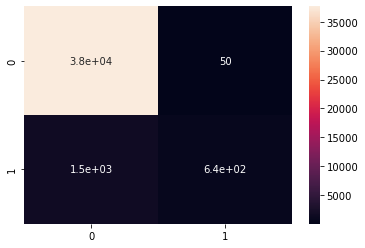

In [19]:
pipe.fit(X_train, y_train.ravel())
preds = pipe.predict(X_test)

print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)

<h2>Threats</h2>

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     39777
           1       0.00      0.00      0.00       116

    accuracy                           1.00     39893
   macro avg       0.50      0.50      0.50     39893
weighted avg       0.99      1.00      1.00     39893



C:\Users\Karen\anaconda3\envs\geo_pan\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Karen\anaconda3\envs\geo_pan\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Karen\anaconda3\envs\geo_pan\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

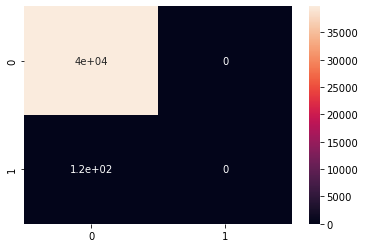

In [20]:
pipe.fit(X2_train, y2_train.ravel())
preds2 = pipe.predict(X2_test)

print(classification_report(y2_test, preds2))
sns.heatmap(confusion_matrix(y2_test, preds2), annot=True)

In [16]:
df_th['threat'].value_counts()

0    159093
1       478
Name: threat, dtype: int64

<p>The results are fairly accurate, except the vectorizer did not get any true positives on threat prediction. This is most likely due to the small amount of messages that are classified as threats.</p>

<h1>Count Vectorizer</h1>
<p>Next I try a count vectorizer, which I also give max features of 150</p>

In [7]:
cv = CountVectorizer(stop_words="english", strip_accents="unicode", max_features=150)

In [15]:
pipe2 = Pipeline([ 
                    ("vect", cv),
                    ("model", model_svc)
])

<h2>Obscene</h2>

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     37709
           1       0.93      0.29      0.44      2184

    accuracy                           0.96     39893
   macro avg       0.94      0.64      0.71     39893
weighted avg       0.96      0.96      0.95     39893



<AxesSubplot:>

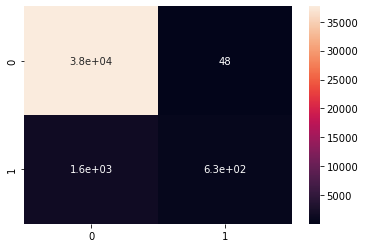

In [23]:
pipe2.fit(X_train, y_train.ravel())
preds3 = pipe2.predict(X_test)

print(classification_report(y_test, preds3))
sns.heatmap(confusion_matrix(y_test, preds3), annot=True)

<h2>Threats</h2>

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     37709
           1       1.00      0.00      0.00      2184

    accuracy                           0.95     39893
   macro avg       0.97      0.50      0.49     39893
weighted avg       0.95      0.95      0.92     39893



<AxesSubplot:>

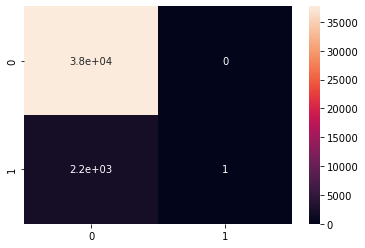

In [24]:
pipe2.fit(X2_train, y2_train.ravel())
preds4 = pipe2.predict(X_test)

print(classification_report(y_test, preds4))
sns.heatmap(confusion_matrix(y_test, preds4), annot=True)

<h1>Which Model<h1>
<p>The count vectorizer and the tdif vectorizer were nearly identical when predicting the "Obscene Column"</p>
<p>The count vectorizer gave sligtly better results when analyzing the "Threat Column"</p>
<p>So I have chosen to use the count vectorizer for both columns.</p>

In [8]:
y_train_ob = df_ob["obscene"]
X_train_ob = df_ob["comment_text"]

y_train_th = df_th["threat"]
X_train_th = df_th["comment_text"]

In [9]:
X_test_ = df2['comment_text']

In [10]:
pipe_ob = Pipeline([ 
                    ("vect", cv),
                    ("model", model_svc)
])

pipe_th = Pipeline([ 
                    ("vect", cv),
                    ("model", model_svc)
])

In [11]:
pipe_ob.fit(X_train_ob, y_train_ob.ravel())
preds_ob = pipe_ob.predict(X_test_)

In [14]:
preds_ob_ = pd.DataFrame(preds_ob)
preds_ob_.index = preds_ob_.index + 1

In [23]:
preds_ob_.to_csv('obscene.csv')